In [12]:
import xgboost as xgb
import polars as pl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
from xgboost import plot_tree, DMatrix
import matplotlib.pyplot as plt
import graphviz
from xgboost import to_graphviz
import polars as pl
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import DMatrix
import os
import xgboost
from graphviz import Source
import subprocess
import logging

In [13]:
df = pl.read_csv("all_final_data_2011.csv")
df

LSOA,Mean_Household_Income,Energy Efficiency,Fuel Poverty,No central heating,Gas,Electric,Oil,Solid fuel,Other including communal and renewable,Two or more types,1 bedroom,2 bedrooms,3 bedrooms,4 or more bedrooms,Owned outright,Owned with a mortgage or loan,Shared ownership,Rented from Local Authority,Other social rented,Private landlord or letting agency,Other private rented,Rent free,Year_built
str,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""E01000001""",74846,57.87683,4.2,10,82,572,10,0,189,13,416,250,155,43,355,178,3,33,8,247,17,35,1972
"""E01000002""",73325,65.359492,2.1,15,40,538,6,0,220,11,402,274,87,65,314,213,8,44,4,206,13,28,1972
"""E01000003""",44130,61.372987,5.5,23,498,209,1,0,69,17,501,232,46,3,184,143,1,239,56,166,11,17,1972
"""E01000005""",30781,66.293588,7.9,9,225,98,25,0,88,22,241,130,79,7,24,22,0,133,179,92,9,8,1982
"""E01032739""",68022,57.052271,16.7,54,250,335,3,0,25,9,353,256,34,24,104,88,1,5,6,358,29,85,1900
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""E01033601""",37445,68.637239,4.6,10,415,98,1,0,37,28,172,205,129,76,57,64,5,233,148,70,5,7,1982
"""E01033602""",33823,68.552885,4.5,34,455,49,1,1,69,36,251,200,151,39,48,44,9,263,148,121,5,7,1972
"""E01033603""",48140,65.132701,5.1,25,430,100,1,0,14,30,238,244,89,27,78,75,6,118,95,209,8,11,1900


**Load all the data in the heatings dataset into numpy arrays structure**

In [14]:
def load_data(file_path: str, feature_columns: list, target_column: str):
    """
    Load the dataset, normalize column names, and ensure all specified feature
    and target columns exist.
    """
    import polars as pl
    
    # Load data
    data = pl.read_csv(file_path)
    
    # Normalize DataFrame columns by stripping spaces and converting to lowercase
    normalized_columns = [col.strip().lower() for col in data.columns]
    data.columns = normalized_columns  # Update DataFrame columns
    
    # Normalize input feature and target column names
    normalized_feature_columns = [col.strip().lower() for col in feature_columns]
    normalized_target_column = target_column.strip().lower()
    
    # Debugging: Print normalized column names
    print(f"Normalized Dataset Columns: {data.columns}")
    
    # Verify feature and target columns
    missing_features = [col for col in normalized_feature_columns if col not in data.columns]
    if missing_features:
        raise ValueError(f"Missing feature columns in the dataset: {missing_features}")

    if normalized_target_column not in data.columns:
        raise ValueError(f"Missing target column in the dataset: {normalized_target_column}")

    # Select features and target based on normalized column names
    X = data.select(normalized_feature_columns)
    y = data.select(normalized_target_column)
    
    return X.to_numpy(), y.to_numpy().flatten()

**Loading the training data for the XGBoost Training**

In [15]:
def train_xgb_model_with_features(X_train, y_train, X_test, y_test, feature_columns):
    """
    Train an XGBoost model using the provided train/test data and compute performance metrics.

    Parameters:
        X_train (numpy.ndarray): Training features.
        y_train (numpy.ndarray): Training target values.
        X_test (numpy.ndarray): Testing features.
        y_test (numpy.ndarray): Testing target values.
        feature_columns (list): List of feature names.

    Returns:
        model: Trained XGBoost model.
        dict: Performance metrics.
    """
    import xgboost as xgb
    from sklearn.metrics import mean_squared_error, r2_score

    try:
        # Create DMatrix for XGBoost
        dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_columns)
        dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_columns)
        
        # Define XGBoost parameters
        params = {
            "objective": "reg:squarederror",  # Use squared error for regression
            "eval_metric": "rmse",           # Root mean squared error as metric
            "max_depth": 6,                  # Limit tree depth
            "eta": 0.1,                      # Learning rate
            "verbosity": 1,                  # Verbosity of logging
        }

        # Train the model
        evals = [(dtrain, "train"), (dtest, "test")]
        model = xgb.train(params, dtrain, num_boost_round=200, evals=evals, early_stopping_rounds=10)

        # Predict on test data
        y_pred = model.predict(dtest)

        # Compute performance metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse ** 0.5
        r2 = r2_score(y_test, y_pred)

        performance_metrics = {
            "mse": mse,
            "rmse": rmse,
            "r2_score": r2
        }

        return model, performance_metrics
    except Exception as e:
        raise RuntimeError(f"Error while training model: {e}")

**Main Operation**

In [16]:
# Step 1: Load dataset
file_path = "all_final_data_2011.csv"  # Replace with your CSV file path
feature_columns = ['gas', 'no central heating', 'electric', 'oil', 'solid fuel', 'other including communal and renewable', 'two or more types'] 
target_column = "Energy Efficiency"

# Load dataset
X, y = load_data(file_path, feature_columns, target_column)

# Split train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model, metrics = train_xgb_model_with_features(X_train, y_train, X_test, y_test, feature_columns)

# Print results
print(f"Model Metrics: {metrics}")

Normalized Dataset Columns: ['lsoa', 'mean_household_income', 'energy efficiency', 'fuel poverty', 'no central heating', 'gas', 'electric', 'oil', 'solid fuel', 'other including communal and renewable', 'two or more types', '1 bedroom', '2 bedrooms', '3 bedrooms', '4 or more bedrooms', 'owned outright', 'owned with a mortgage or loan', 'shared ownership', 'rented from local authority', 'other social rented', 'private landlord or letting agency', 'other private rented', 'rent free', 'year_built']
[0]	train-rmse:4.66762	test-rmse:4.65021
[1]	train-rmse:4.48519	test-rmse:4.49826
[2]	train-rmse:4.32484	test-rmse:4.37005
[3]	train-rmse:4.18441	test-rmse:4.25298
[4]	train-rmse:4.06350	test-rmse:4.15465


[5]	train-rmse:3.96222	test-rmse:4.07772
[6]	train-rmse:3.87074	test-rmse:4.01383
[7]	train-rmse:3.78462	test-rmse:3.95838
[8]	train-rmse:3.71310	test-rmse:3.91085
[9]	train-rmse:3.64912	test-rmse:3.87344
[10]	train-rmse:3.59419	test-rmse:3.83307
[11]	train-rmse:3.54422	test-rmse:3.80481
[12]	train-rmse:3.49651	test-rmse:3.77891
[13]	train-rmse:3.45495	test-rmse:3.75688
[14]	train-rmse:3.41604	test-rmse:3.73286
[15]	train-rmse:3.38447	test-rmse:3.71828
[16]	train-rmse:3.35695	test-rmse:3.70420
[17]	train-rmse:3.33094	test-rmse:3.68982
[18]	train-rmse:3.30901	test-rmse:3.68107
[19]	train-rmse:3.28338	test-rmse:3.67640
[20]	train-rmse:3.25721	test-rmse:3.67084
[21]	train-rmse:3.23405	test-rmse:3.66300
[22]	train-rmse:3.20824	test-rmse:3.65657
[23]	train-rmse:3.18746	test-rmse:3.65511
[24]	train-rmse:3.16773	test-rmse:3.64860
[25]	train-rmse:3.14765	test-rmse:3.64202
[26]	train-rmse:3.13072	test-rmse:3.63995
[27]	train-rmse:3.11283	test-rmse:3.63429
[28]	train-rmse:3.10051	test-rmse:3.631

**Display the Results**

In [17]:
def plot_feature_importance(model, feature_names, normalize=False):
    """
    Visualize the feature importance of an XGBoost model, with optional normalization.
    Parameters:
    - model: Trained XGBoost model (can be XGBRegressor or XGBClassifier).
    - feature_names: List of feature names used during training.
    - normalize: Whether to normalize the feature importance scores so they sum to 100 (default: False).
    """
    # Retrieve feature importance scores (raw counts of splits for each feature)
    importance_dict = model.get_score(importance_type='weight')
    
    # Use the importance dictionary directly (keys are feature names)
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    
    # Extract feature names and their importance scores
    features, scores = zip(*sorted_importance)
    
    if normalize:
        # Normalize scores so they sum to 100
        total = sum(scores)
        scores = [(score / total) * 100 for score in scores]
    
    # Plot the feature importances
    plt.figure(figsize=(10, 8))
    y_positions = np.arange(len(features))  # Define y-axis positions for the bars
    bars = plt.barh(y_positions, scores, color="#2E6EFF")
    
    # Add percentage labels on the right-hand side of the bars
    for i, score in enumerate(scores):
        plt.text(score + 0.5, i, f"{score:.1f}%", va="center", fontsize=15, color="black")
    
    # Reverse the order to have the most important on top
    plt.gca().invert_yaxis()
    
    # Set axis labels and title with increased font size
    plt.xlabel("Feature Importance (%)" if normalize else "Feature Importance (Weight)", fontsize=15)
    plt.ylabel("Features", fontsize=15)
    plt.title("Heating Feature Importance", fontsize=15)
    
    # Adjust the x-axis scale to a maximum of 35%
    plt.xlim(0, 35)
    
    # Set y-axis ticks to feature names with increased font size
    plt.yticks(y_positions, features, fontsize=15)
    plt.xticks(fontsize=15)  # Increase font size of x-axis tick labels
    
    # Show the plot
    plt.show()

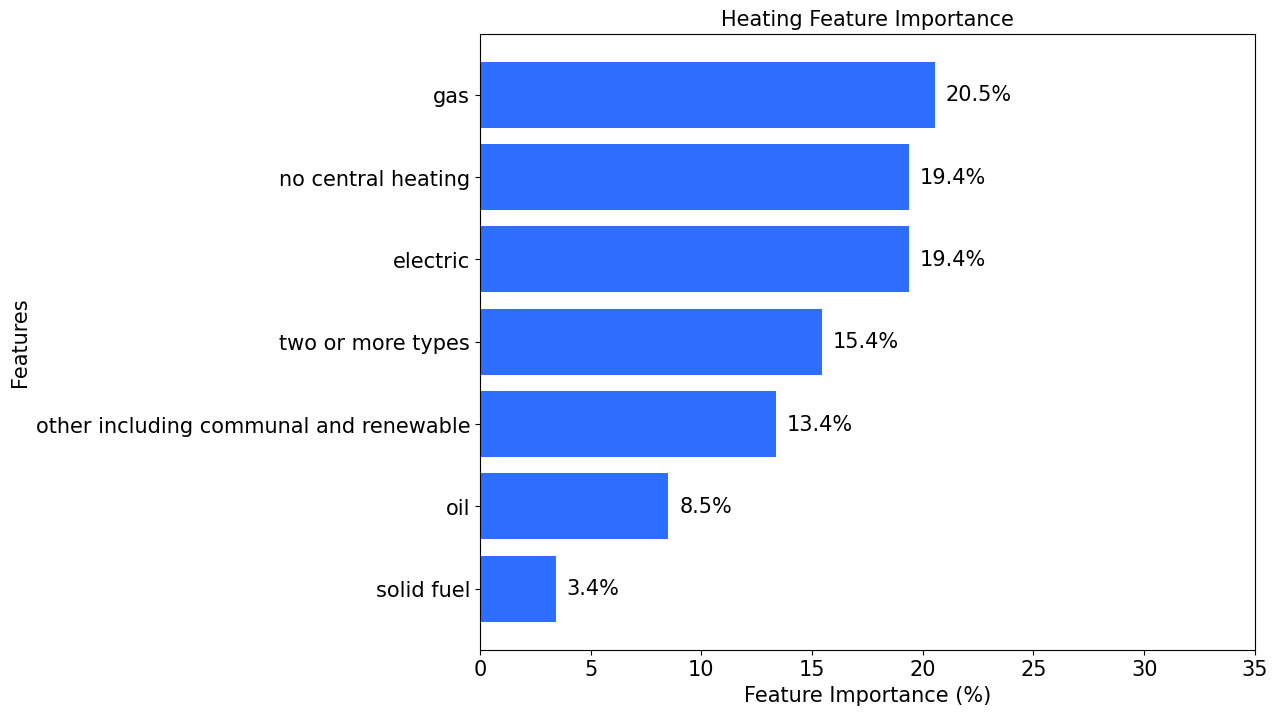

In [18]:
plot_feature_importance(model, feature_columns, normalize=True)

**Feature Importance Rank**

In [19]:
def feature_importance_rate(model, feature_names):
    """
    Visualize feature importance normalized to sum to 1. 
    
    Parameters:
    - model: Trained XGBoost model (XGBRegressor or XGBClassifier)
    - feature_names: List of feature names used during training
    """
    # Extract feature importance scores (split counts)
    importance_dict = model.get_score(importance_type='weight')
    
    # Create sorted list of (feature, score) tuples
    sorted_importance = sorted(importance_dict.items(), 
                              key=lambda x: x[1], 
                              reverse=True)
    # Calculate the total sum of the values
    total = sum(value for _, value in sorted_importance)

    # Normalize each value by dividing it by the total sum
    normalized_list = [(category, value / total) for category, value in sorted_importance]

    return normalized_list

**Return Overall Heating Score for Each LSOA**

In [20]:
def calculate_weighted_score(df, feature_weights, feature_name):
    """
    Calculate weighted score using Polars operations.

    Args:
        df: Polars DataFrame containing features
        feature_weights: List of (feature_name, weight) tuples

    Returns:
        Polars DataFrame with new 'Fuel_Poverty_Score' column
    """
    import polars as pl
    import logging

    # Set up logging to report any issues.
    logging.basicConfig(level=logging.WARNING)

    # Normalize DataFrame column names and feature_weights keys (to lowercase, stripped of whitespace).
    normalized_df_columns = {col.strip().lower(): col for col in df.columns}
    normalized_feature_weights = {key.strip().lower(): weight for key, weight in feature_weights}

    # Identify which columns in feature_weights exist in the DataFrame after normalization.
    valid_columns = []
    for col, weight in normalized_feature_weights.items():
        if col in normalized_df_columns:
            valid_columns.append((normalized_df_columns[col], weight))
        else:
            logging.warning(f"Column '{col}' (after normalization) not found in the DataFrame and will be skipped.")

    # If no valid columns are found, log an overall warning and return the original DataFrame unmodified.
    if not valid_columns:
        logging.warning("No valid columns from feature_weights were found in the DataFrame. Returning original DataFrame.")
        return df

    # Compute the weighted sum expression using valid columns.
    sum_expr = sum(pl.col(col) * weight for col, weight in valid_columns)

    # Add the result as a new column to the DataFrame under 'Fuel_Poverty_Score'.
    df = df.with_columns(
        sum_expr.alias(feature_name)
    )

    return df

**Process the Data into CSV**

In [21]:
def process_data():
    # Load data (replace with your actual data loading code)
    df = pl.read_csv('all_final_data_2011.csv')
    
    # Your provided feature weights - make sure these match column names in dataframe
    feature_weights_heating = [
        ('Gas', 0.20536100302637267),
        ('No central heating', 0.19368785127539992),
        ('Electric', 0.19368785127539992),
        ('Two or more types', 0.1543450064850843),
        ('Other including communal and renewable', 0.13359273670557717),
        ('Oil', 0.0851707738867272),
        ('Solid fuel', 0.03415477734543882)
    ]

    feature_weights_ownership = [('Owned outright', 0.1624659400544959), ('Rented from Local Authority', 0.1624659400544959), ('Owned with a mortgage or loan', 0.14134877384196184), ('Other social rented', 0.1273841961852861), ('Private landlord or letting agency', 0.1273841961852861), ('Shared ownership', 0.10047683923705722), ('Rent free', 0.09366485013623978), ('Other private rented', 0.08480926430517712)]

    feature_name_heating = "Heating Score"
    
    # Calculate scores
    df = calculate_weighted_score(df, feature_weights_heating, feature_name_heating)

    feature_name_ownership = "Ownership Score"

    df = calculate_weighted_score(df, feature_weights_ownership, feature_name_ownership)
    
    return df

**Drop Unrelevant Column**

In [22]:
# Step 1: Process data to generate the initial DataFrame
df = process_data()  # replace this with your data processing logic

# Step 2: Check initial columns
print("Columns before normalization and dropping:", df.columns)

# Step 3: Normalize column names in the DataFrame (case-insensitive comparison)
df = df.rename({col: col.strip().lower() for col in df.columns})

# Step 4: Normalize the columns_to_drop list
columns_to_drop = [
    col.strip().lower() for col in [
        'No central heating', 'Gas', 'Electric', 'Oil', 'Solid fuel',
        'Other including communal and renewable', 'Two or more types',
        '1 bedroom', '2 bedrooms', '3 bedrooms', '4 or more bedrooms',
        'Owned outright', 'Owned with a mortgage or loan', 'Shared ownership',
        'Rented from Local Authority', 'Other social rented',
        'Private landlord or letting agency', 'Other private rented',
        'Rent free'
    ]
]

# Step 5: Identify columns to drop based on actual DataFrame columns
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Step 6: Drop the matching columns
df = df.drop(columns_to_drop)

# Step 7: Verify remaining columns
print("Columns after dropping:", df.columns)

df.write_csv("output_with_scores.csv")

Columns before normalization and dropping: ['LSOA', 'Mean_Household_Income', 'Energy Efficiency', 'Fuel Poverty', 'No central heating', 'Gas ', 'Electric', 'Oil ', 'Solid fuel', 'Other including communal and renewable ', 'Two or more types ', '1 bedroom', '2 bedrooms', '3 bedrooms', '4 or more bedrooms', 'Owned outright', 'Owned with a mortgage or loan', 'Shared ownership ', 'Rented from Local Authority', 'Other social rented', 'Private landlord or letting agency', 'Other private rented', 'Rent free', 'Year_built', 'Heating Score', 'Ownership Score']
Columns after dropping: ['lsoa', 'mean_household_income', 'energy efficiency', 'fuel poverty', 'year_built', 'heating score', 'ownership score']
